In [2]:
import numpy as np
import scipy.stats
from math import e
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
from tqdm import tqdm
from scipy.stats import norm
import datetime
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns
import scipy.stats as stats
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import datetime
from fbm import FBM
from tqdm import tqdm

In [3]:
class Link:
    def __init__(self, value, next):
        self.value = value
        self.next = next

    def setValue(value):
        self.value = value

    def setNext(next):
        self.next = next

class LinkedList:
    def __init__(self, value, maxlen):
        head = Link(value, None)
        self.head = head
        self.last = head
        self.lenght = 1
        self.maxlen = maxlen

    def addLast(self, value):
        node = Link(value, None)
        if (self.lenght < self.maxlen):
            self.last.next = node
            self.last = node
            self.lenght += 1
        else:
            self.last.next = node
            self.last = node
            self.head = self.head.next

    def getValues(self):
        res = []
        cur = self.head
        for i in range (self.lenght):
            res.append(cur.value)
            cur = cur.next
        return res


In [4]:
class HestonRoughModel:
    def __init__(self, m, T, Lambd, alpha, maxlen, K1, K2, beta):
        self.m = m
        self.T = T
        self.Lambd = Lambd
        self.alpha = alpha
        self.maxlen = maxlen
        self.K1 = K1
        self.K2 = K2
        self.beta = beta
        self.init_variables()

    def init_variables(self):
        a_T = 1 - self.Lambd / self.T ** self.alpha
        mu_T = self.m / self.T ** (1 - self.alpha)
        self.N = np.array([[50.], [50.]])
        self.lambd = np.zeros((2, 1))
        self.dN = LinkedList(np.zeros((2, 1)), self.maxlen)
        self.mu = np.full((2, 1), mu_T)
        self.phi = [a_T * self.PHI(t) for t in range(self.maxlen)]

    def phi_1(self, t):
        return self.K1 / (1 + pow(t, 1 + self.alpha))

    def phi_2(self, t):
        return self.K2 / (1 + pow(t, 1 + self.alpha))

    def PHI(self, t):
        return np.array([[self.phi_1(t), self.beta * self.phi_2(t)],
                         [self.phi_2(t), self.phi_1(t) + (self.beta - 1) * self.phi_2(t)]])

    def integr(self, t):
        res = np.zeros((2, 1))
        dnlist = self.dN.getValues()
        start = 0 if t < self.maxlen else t - self.maxlen + 1
        for s in range(start, t):
            index = s - t + self.maxlen - 1 if t >= self.maxlen else s
            dn = np.reshape(dnlist[index], (2, 1))
            res += np.dot(self.phi[t - s], dn)
        return res

    def evolue(self, lambd):
        events = np.random.random(2) <= lambd.reshape(2)
        return events.astype(int).reshape(2, 1)

    def simul(self,T):
        self.init_variables()
        P = np.zeros(T + 1)
        P[0] = 0
        for t in tqdm(range(1, T + 1), desc='Processing'):
            lambd = self.mu + self.integr(t - 1)
            dn = self.evolue(lambd)
            self.dN.addLast(dn)
            self.N += dn
            P[t] = self.N[0, 0] - self.N[1, 0]
        return P

    def figure(self):
        t = np.arange(self.T)
        p = self.simul(T= self.T **2 )
        P = np.array([1 / self.T * p[t * self.T] for t in range(self.T)])
        P += 2 * np.abs(np.min(P))
        title = ("Heston Rough, T = {}, mu = {:.2f}, beta = {:.2f}, "
                 "Lambda = {:.2f}, alpha = {:.2f}, K1 = {:.2f}, K2 = {:.2f}").format(
                 self.T, self.m / np.power(self.T, 1 - self.alpha), self.beta, self.Lambd, self.alpha, self.K1, self.K2)
        plt.plot(t, P)
        plt.title(title)
        plt.show()
        filename = ("Heston_Rough_T_{}_mu_{:.2f}_beta_{:.2f}_Lambda_{:.2f}_"
                    "alpha_{:.2f}_K1_{:.2f}_K2_{:.2f}.csv").format(
                    self.T, self.m / np.power(self.T, 1 - self.alpha), self.beta, self.Lambd, self.alpha, self.K1, self.K2)
        df = pd.DataFrame(data={'P': P})
        df.to_csv(filename, index=False)


In [88]:
RH1= HestonRoughModel(m = 0.23,T = 3000, beta = 1.1,Lambd = 1,alpha = 0.6,K1 = 0.3,K2 = (1/2.1253-0.3)/1.1, maxlen = 50)


Processing: 100%|██████████| 9000000/9000000 [16:54<00:00, 8872.78it/s] 


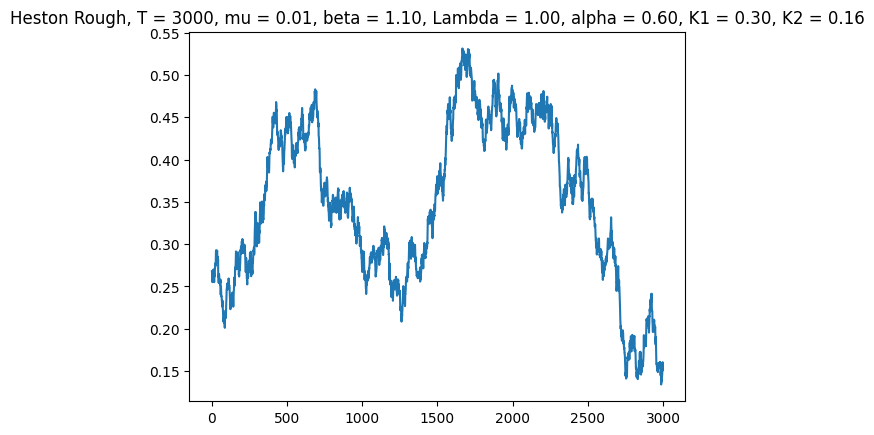

In [89]:
RH1.figure()

In [5]:
data =  pd.read_csv("Heston_Rough_T_1000_mu_0.01_beta_1.10_Lambda_1.00_alpha_0.60_K1_0.30_K2_0.16.csv")

<Axes: >

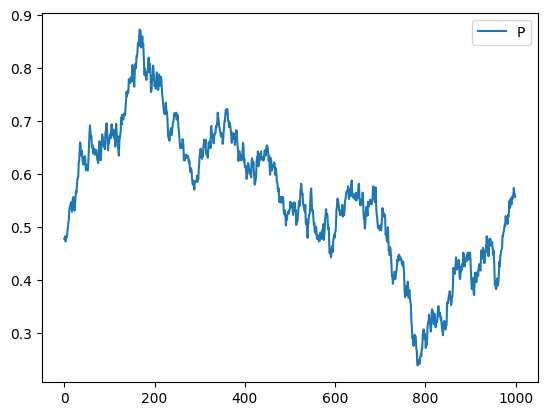

In [6]:
data.plot()

In [7]:
data['Log_Returns'] = np.log(data['P'] / data['P'].shift(1))
window_size = 30  
data['Volatility'] = data['Log_Returns'].rolling(window=20).std() 
data['Log_Volatility'] = np.log(data['Volatility'])
print(data[['P', 'Log_Returns', 'Volatility', 'Log_Volatility']])

         P  Log_Returns  Volatility  Log_Volatility
0    0.478          NaN         NaN             NaN
1    0.478     0.000000         NaN             NaN
2    0.483     0.010406         NaN             NaN
3    0.473    -0.020921         NaN             NaN
4    0.480     0.014691         NaN             NaN
..     ...          ...         ...             ...
995  0.563     0.008921    0.019923       -3.915891
996  0.574     0.019350    0.020132       -3.905430
997  0.565    -0.015804    0.020566       -3.884108
998  0.562    -0.005324    0.019326       -3.946292
999  0.557    -0.008937    0.018801       -3.973832

[1000 rows x 4 columns]


<Axes: >

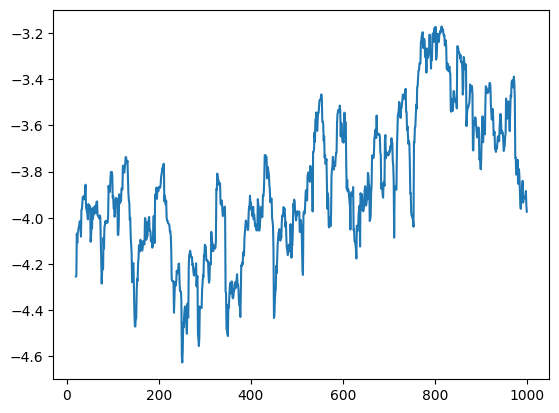

In [8]:
data['Log_Volatility'].plot()

In [9]:
import matplotlib.pyplot as plt

In [10]:
def del_Raw(q, x): 
    return [np.mean(np.abs(data['Log_Volatility'] - data['Log_Volatility'].shift(lag)) ** q)
            for lag in x]

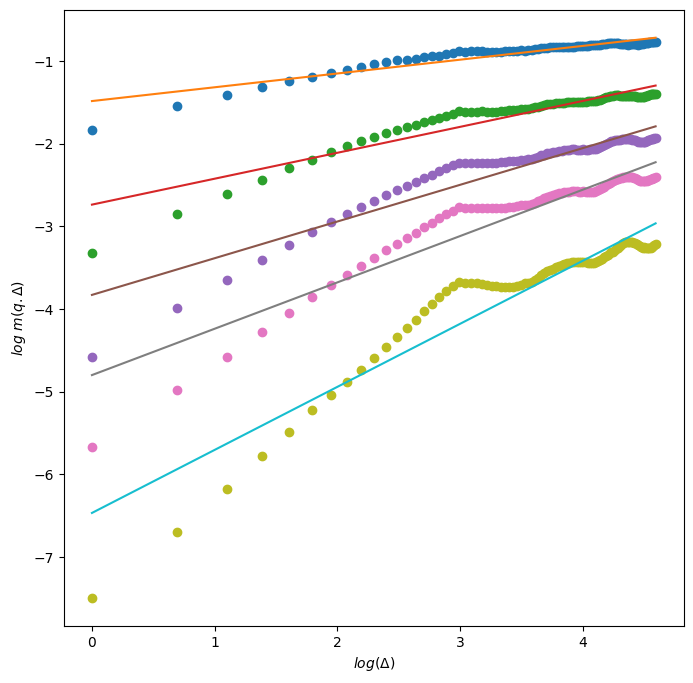

In [11]:
plt.figure(figsize=(8, 8))
plt.xlabel('$log(\Delta)$')
plt.ylabel('$log\  m(q.\Delta)$')
plt.ylim=(-3, -.5)

zeta_q = []
qVec = np.array([.5, 1, 1.5, 2, 3])
x = np.arange(1, 100)
for q in qVec:
    plt.plot(np.log(x), np.log(del_Raw(q, x)), 'o') 
    model = np.polyfit(np.log(x), np.log(del_Raw(q, x)), 1)
    plt.plot(np.log(x), np.log(x) * model[0] + model[1])
    zeta_q.append(model[0])


0.2622761023440059


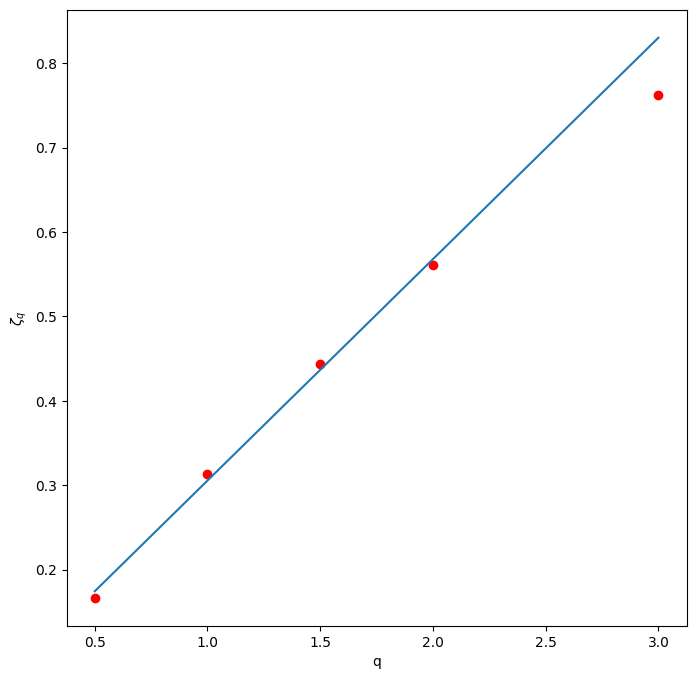

In [12]:
plt.figure(figsize=(8,8))
plt.xlabel('q')
plt.ylabel('$\zeta_{q}$')
plt.plot(qVec, zeta_q, 'or')

line = np.polyfit(qVec[:4], zeta_q[:4],1)
plt.plot(qVec, line[0] * qVec + line[1])
h_est= line[0]
print(h_est)

In [13]:
H =0.26

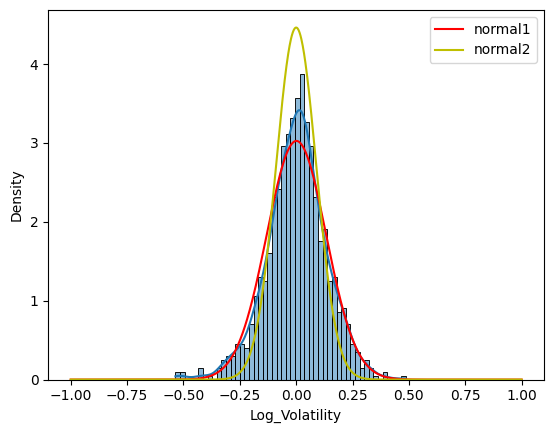

In [19]:
x = np.linspace(-1,1,1000)
increment5 =data['Log_Volatility'].diff(5).dropna()
mu5 = np.mean(increment5,axis = 0)
sigma5 = np.std(increment5,axis = 0)
sigma1 = np.std(data['Log_Volatility'].diff().dropna())
# Add the plot of N(\mu,\sigma) pdf on top of the seaborn histogram
plt.figure()
sns_ax = sns.histplot(data=increment5, bins=50, stat="density", kde=True)
sns_ax.plot(x,norm.pdf(x,mu5,sigma5),label="normal1",color = 'r')
sns_ax.plot(x,norm.pdf(x,0,sigma1 *(5 ** H)),label="normal2",color = 'y')
plt.legend()